In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ranges_dict = {
    'fio2': [(0.21, 0.4), (0.4, 0.5), (0.5, 0.6), (0.6, 1)],
    'peep': [(5, 7), (7, 9), (9, 11), (11, 13), (13, 20)],
    'vent_rate_set': [(0, 15), (15, 18), (18, 21), (21, 40)],
    'sweep': [(0.25, 2.5), (2.5, 5), (5, 7.5), (7.5, 10), (10, 20)],
    'flow': [(0.5, 3), (3, 4), (4, 5), (5, 6), (6, 10)]
}

In [3]:
data_test = pd.read_csv("../Continuous Data/test_data_continuous_no_R_for_Survival.csv")
target_policy = pd.read_csv("continuous_no_R_cql_restored_actions_new.csv")

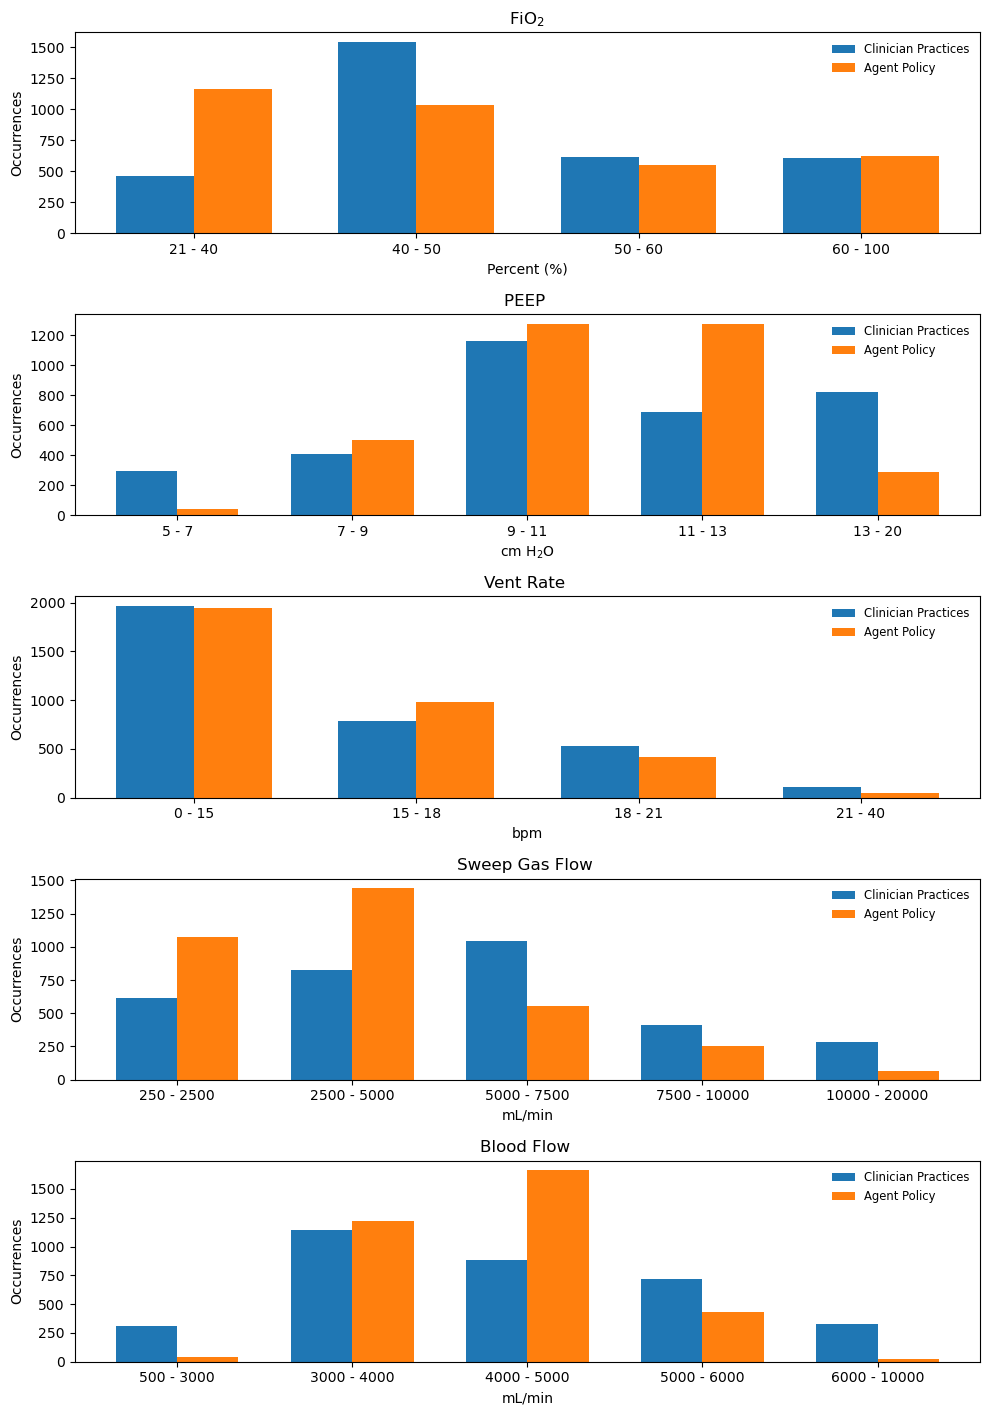

In [7]:
titles = ['FiO$_2$','PEEP','Vent Rate','Sweep Gas Flow','Blood Flow']
fig, axes = plt.subplots(nrows=5, figsize=(10, 15))
for idx, (action, ranges) in enumerate(ranges_dict.items()):
    ax = axes[idx]

    # Prepare bin labels and x-labels
    range_labels = [f"{r[0]} - {r[1]}" for r in ranges]
    if action == 'fio2':
        range_labels = [f"{int(r[0]*100)} - {int(r[1]*100)}" for r in ranges]
        xlabel = 'Percent (%)'
    elif action == 'peep':
        xlabel = 'cm H$_2$O'
    elif action == 'vent_rate_set':
        xlabel = 'bpm'
    elif action == 'sweep':
        range_labels = [f"{int(r[0]*1000)} - {int(r[1]*1000)}" for r in ranges]
        xlabel = 'mL/min'
    elif action == 'flow':
        range_labels = [f"{int(r[0]*1000)} - {int(r[1]*1000)}" for r in ranges]
        xlabel = 'mL/min'

    # Count how many times each DataFrame's values fall into each bin
    counts_test = []
    counts_target = []
    for (lower, upper) in ranges:
        count_test = ((data_test[action] >= lower) & (data_test[action] < upper)).sum()
        count_target = ((target_policy[action] >= lower) & (target_policy[action] < upper)).sum()
        counts_test.append(count_test)
        counts_target.append(count_target)

    x = np.arange(len(ranges))
    bar_width = 0.35

    # Grouped bar plot
    ax.bar(x - bar_width/2, counts_test, width=bar_width, label='Clinician Practices')
    ax.bar(x + bar_width/2, counts_target, width=bar_width, label='Agent Policy')

    ax.set_xticks(x)
    ax.set_xticklabels(range_labels)
    ax.set_ylabel('Occurrences')
    ax.set_xlabel(xlabel)
    ax.set_title(f'{titles[idx]} ')
    ax.legend(fontsize='small', frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

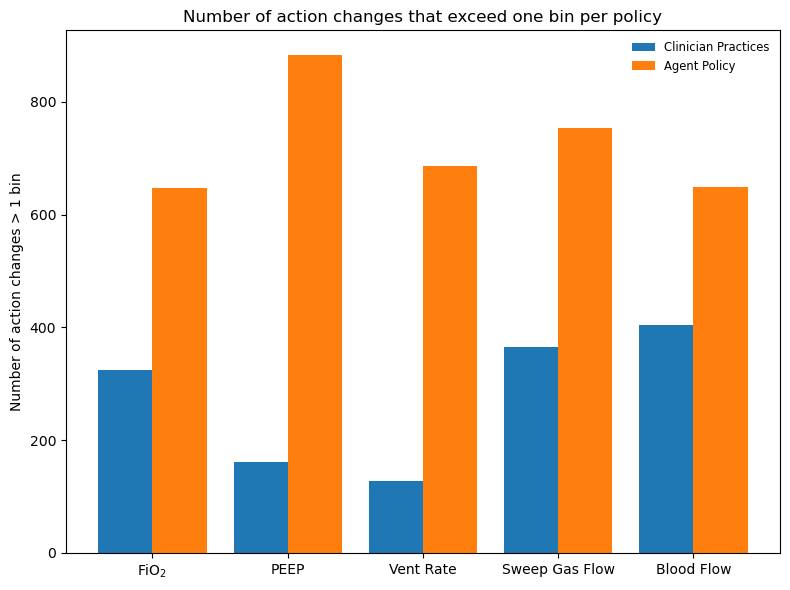

In [8]:
def get_bin_index(val, bins):
    for i, (lower, upper) in enumerate(bins):
        if lower <= val < upper:
            return i
    return None

fig, ax = plt.subplots(figsize=(8, 6))

exceed_counts_behavior = []
exceed_counts_target = []

for action, ranges in ranges_dict.items():
    behavior_indices = [get_bin_index(val, ranges) for val in data_test[action]]
    target_indices = [get_bin_index(val, ranges) for val in target_policy[action]]
    behavior_changes = 0
    target_changes = 0
    for i in range(len(behavior_indices) - 1):
        if behavior_indices[i] is not None and behavior_indices[i+1] is not None:
            if abs(behavior_indices[i+1] - behavior_indices[i]) >= 1:
                behavior_changes += 1
    for i in range(len(target_indices) - 1):
        if target_indices[i] is not None and target_indices[i+1] is not None:
            if abs(target_indices[i+1] - target_indices[i]) >= 1:
                target_changes += 1
    exceed_counts_behavior.append(behavior_changes)
    exceed_counts_target.append(target_changes)

x = np.arange(len(ranges_dict))
bar_width = 0.4

ax.bar(x - bar_width/2, exceed_counts_behavior, width=bar_width, label='Clinician Practices')
ax.bar(x + bar_width/2, exceed_counts_target, width=bar_width, label='Agent Policy')
ax.set_xticks(x)
ax.set_xticklabels(titles)
ax.set_ylabel("Number of action changes > 1 bin")
ax.set_title("Number of action changes that exceed one bin per policy")
ax.legend(fontsize='small', frameon=False)
plt.tight_layout()
plt.savefig("action changes.png")
plt.show()
